# Model Selection

## Mục tiêu

- So sánh hiệu suất tất cả các mô hình trên tập validation
- Xác định mô hình tốt nhất dựa trên MAE loss
- Dự đoán tuổi thọ trên tập test sử dụng mô hình tốt nhất
- Phân tích kết quả dự đoán trên test set, bao gồm:
  - Kết quả dự đoán chi tiết cho từng quốc gia
  - So sánh validation vs test performance (phát hiện overfitting)
  - Phân tích lỗi theo các nhóm tuổi thọ
  - Vẽ biểu đồ insights

## Bước 1 - Import các thư viện cần thiết

In [11]:
import os
import joblib
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

# Set style cho biểu đồ
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Bước 2 - Đọc dữ liệu validation và test

In [12]:
# Đọc dữ liệu
val_df = pd.read_csv('../data/processed/val.csv')
test_df = pd.read_csv('../data/processed/test.csv')

print("THÔNG TIN DỮ LIỆU VALIDATION VÀ TEST")
print("="*60)
print(f"Kích thước tập validation: {val_df.shape}")
print(f"Kích thước tập test: {test_df.shape}")

# Định nghĩa các cột dùng để dự đoán
feature_cols = [col for col in val_df.columns
                if col not in ['life_expectancy', 'country_name', 'country_code']]

# Tách X và y cho tập validation
X_val = val_df[feature_cols]
y_val = val_df['life_expectancy']

# Tách X và y cho tập test
X_test = test_df[feature_cols]
y_test = test_df['life_expectancy']

print(f"\nSố lượng đặc trưng: {len(feature_cols)}")

THÔNG TIN DỮ LIỆU VALIDATION VÀ TEST
Kích thước tập validation: (1085, 13)
Kích thước tập test: (1085, 13)

Số lượng đặc trưng: 10


## Bước 3 - Load tất cả các mô hình

In [13]:
BASE_DIR = Path('../models')

# Dictionary lưu các mô hình
models = {}

# ===== 1. Linear Models =====
models['Linear'] = joblib.load(BASE_DIR / "1_linear_regression" / "linear.pkl")
models['Ridge'] = joblib.load(BASE_DIR / "1_linear_regression" / "ridge.pkl")
models['Lasso'] = joblib.load(BASE_DIR / "1_linear_regression" / "lasso.pkl")

# ===== 2. SVM =====
models['LinearSVR'] = joblib.load(BASE_DIR / "2_SVM_regression" / "linear_svr.pkl")
models['SVR_RBF'] = joblib.load(BASE_DIR / "2_SVM_regression" / "svr_rbf.pkl")

# ===== 3. Decision Tree =====
models['DecisionTree'] = joblib.load(BASE_DIR / "3_decision_tree" / "decision_tree.pkl")

# ===== 4. Random Forest =====
models['RandomForest'] = joblib.load(BASE_DIR / "4_random_forest" / "random_forest.pkl.gz")

# ===== 5. GBM =====
models['GBM'] = joblib.load(BASE_DIR / "5_GBM" / "GBM.pkl.gz")

# ===== 6. LightGBM =====
models['LightGBM'] = joblib.load(BASE_DIR / "6_lightgbm" / "lightgbm.pkl")

# ===== 7. XGBoost =====
models['XGBoost'] = joblib.load(BASE_DIR / "7_xgboost" / "xgboost.pkl.gz")

# ===== 8. CatBoost =====
models['CatBoost'] = joblib.load(BASE_DIR / "8_catboost" / "catboost.pkl.gz")

# ===== 9. Voting Ensemble =====
voting_ensemble_data = joblib.load(BASE_DIR / "9_voting_ensemble" / "voting_ensemble.pkl.gz")
models['Voting_Ensemble'] = voting_ensemble_data['base_models']

# ===== 10. Stacking Ensemble =====
stacking_ensemble_data = joblib.load(BASE_DIR / "10_stacking_ensemble" / "stacking_ensemble.pkl.gz")
models['Stacking_Ensemble'] = stacking_ensemble_data['stacking_model']

print("TẤT CẢ CÁC MÔ HÌNH ĐÃ ĐƯỢC LOAD")
print("="*60)
print(f"Số lượng mô hình: {len(models)}")
for i, model_name in enumerate(models.keys(), 1):
    print(f"{i:2d}. {model_name}")

/home/bonxom/miniconda3/envs/courseML/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bonxom/miniconda3/envs/courseML/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


TẤT CẢ CÁC MÔ HÌNH ĐÃ ĐƯỢC LOAD
Số lượng mô hình: 13
 1. Linear
 2. Ridge
 3. Lasso
 4. LinearSVR
 5. SVR_RBF
 6. DecisionTree
 7. RandomForest
 8. GBM
 9. LightGBM
10. XGBoost
11. CatBoost
12. Voting_Ensemble
13. Stacking_Ensemble


## Bước 4 - Đánh giá tất cả các mô hình trên tập validation

In [4]:
# Đánh giá từng mô hình
val_results = {}

print("ĐÁNH GIÁ VALIDATION")
print("="*90)
print(f"{'Model':<20} | {'MAE':<10} | {'RMSE':<10} | {'R²':<10}")
print("-"*90)

for model_name, model in models.items():
    if model_name != 'Voting_Ensemble':
        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        val_results[model_name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f"{model_name:<20} | {mae:<10.4f} | {rmse:<10.4f} | {r2:<10.4f}")

# Thêm Voting Ensemble
base_models = voting_ensemble_data['base_models']
weights = voting_ensemble_data['weights']

y_val_voting = np.zeros(len(y_val))
for model_name, weight in weights.items():
    model = base_models[model_name]
    y_pred_model = model.predict(X_val)
    y_val_voting += weight * y_pred_model

mae_voting = mean_absolute_error(y_val, y_val_voting)
rmse_voting = np.sqrt(mean_squared_error(y_val, y_val_voting))
r2_voting = r2_score(y_val, y_val_voting)

val_results['Voting_Ensemble'] = {'MAE': mae_voting, 'RMSE': rmse_voting, 'R2': r2_voting}

print(f"{'Voting_Ensemble':<20} | {mae_voting:<10.4f} | {rmse_voting:<10.4f} | {r2_voting:<10.4f}")
print("="*90)


ĐÁNH GIÁ VALIDATION
Model                | MAE        | RMSE       | R²        
------------------------------------------------------------------------------------------
Linear               | 3.1175     | 4.1396     | 0.7614    
Ridge                | 3.1147     | 4.1412     | 0.7612    
Lasso                | 3.1153     | 4.1411     | 0.7612    
LinearSVR            | 3.2239     | 4.4329     | 0.7264    
SVR_RBF              | 2.0659     | 2.9744     | 0.8768    
DecisionTree         | 2.0074     | 3.0187     | 0.8731    
RandomForest         | 0.8646     | 1.3200     | 0.9757    
GBM                  | 0.9184     | 1.3796     | 0.9735    
LightGBM             | 0.8131     | 1.2323     | 0.9789    
XGBoost              | 0.8049     | 1.1977     | 0.9800    
CatBoost             | 0.7922     | 1.1944     | 0.9801    
Stacking_Ensemble    | 0.7702     | 1.1808     | 0.9806    
Voting_Ensemble      | 0.8292     | 1.2098     | 0.9796    


## Bước 5 - Xác định mô hình tốt nhất

Đối với bài toán dự đoán tuổi thọ trung bình của các quốc gia cùng với bộ dữ liệu hiện có, ta sử dụng MAE làm metric chính để chọn ra model tốt nhất. 

Lý do:
1. MAE đo sai số theo đúng đơn vị thực tế (năm tuổi thọ)
- Ví dụ: MAE = 2.3 tức là mô hình sai trung bình 2.3 năm.
- Rất dễ diễn giải, phù hợp cho báo cáo khoa học / y tế / xã hội học.
2. MAE ổn định hơn RMSE trong phân phối tuổi thọ.
- RMSE phạt sai số lớn gấp bình phương, nên khi có nhiều outliers trong bộ dữ liệu:
    - RMSE tăng mạnh
    - Mô hình bị đánh giá sai lệch
- Trong khi đó, MAE đánh giá “đều” toàn bộ quốc gia, giúp mô hình không bị thiên về một nhóm đặc biệt.
3. R² không phù hợp làm metric chọn mô hình do:
- Khó diễn giải theo “tuổi thọ”.
- Phụ thuộc độ rộng phân phối target.

In [5]:
# Tạo DataFrame từ kết quả validation
val_df_results = pd.DataFrame(val_results).T.reset_index()
val_df_results.columns = ['Model', 'MAE', 'RMSE', 'R2']
val_df_results = val_df_results.sort_values('MAE').reset_index(drop=True)

print("\nBÁNG XẾP HẠNG MÔ HÌNH (Sắp xếp theo MAE)")
print("="*90)
display(val_df_results)

# Xác định mô hình tốt nhất
best_model_name = val_df_results.iloc[0]['Model']
best_mae = val_df_results.iloc[0]['MAE']
best_rmse = val_df_results.iloc[0]['RMSE']
best_r2 = val_df_results.iloc[0]['R2']

print("\n" + "="*90)
print(f"MÔ HÌNH TỐT NHẤT: {best_model_name}")
print("-"*90)
print(f"MAE  : {best_mae:.4f}")
print(f"RMSE : {best_rmse:.4f}")
print(f"R²   : {best_r2:.4f}")


BÁNG XẾP HẠNG MÔ HÌNH (Sắp xếp theo MAE)


,Model,MAE,RMSE,R2
0,Stacking_Ensemble,0.770156,1.180797,0.980588
1,CatBoost,0.792181,1.194432,0.980137
2,XGBoost,0.804866,1.197728,0.980027
3,LightGBM,0.813088,1.232324,0.978857
4,Voting_Ensemble,0.829191,1.209784,0.979623
5,RandomForest,0.864599,1.319981,0.975742
6,GBM,0.918361,1.379568,0.973503
7,DecisionTree,2.007365,3.018725,0.873129
8,SVR_RBF,2.065888,2.974395,0.876827
9,Ridge,3.114699,4.141249,0.761230



MÔ HÌNH TỐT NHẤT: Stacking_Ensemble
------------------------------------------------------------------------------------------
MAE  : 0.7702
RMSE : 1.1808
R²   : 0.9806


Mô hình tốt nhất tìm được là CatBoost Regressor. Xét trên tập validation, CatBoost cho kết quả tốt hơn hẳn các mô hình còn lại dựa trên cả 3 metrics: MAE, RMSE, R2.

## Bước 6 - Dự đoán trên tập test sử dụng mô hình tốt nhất

### 6.1. Đánh giá mô hình trên tập test sử dụng 3 metrics: MAE, RMSE và R2

In [6]:
# Load mô hình tốt nhất
if best_model_name == 'Voting_Ensemble':
    y_test_pred = np.zeros(len(y_test))
    for model_name, weight in weights.items():
        model = base_models[model_name]
        y_pred_model = model.predict(X_test)
        y_test_pred += weight * y_pred_model
else:
    best_model = models[best_model_name]
    y_test_pred = best_model.predict(X_test)

# Tính metrics trên test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\nKẾT QUẢ DỰ ĐOÁN TRÊN TẬP TEST")
print("="*90)
print(f"Mô hình: {best_model_name}")
print("-"*90)
print(f"MAE  : {test_mae:7.4f}")
print(f"RMSE : {test_rmse:7.4f}")
print(f"R²   : {test_r2:7.4f}")


KẾT QUẢ DỰ ĐOÁN TRÊN TẬP TEST
Mô hình: CatBoost
------------------------------------------------------------------------------------------
MAE  :  0.8081
RMSE :  1.3471
R²   :  0.9754


### 6.2. Kết quả dự đoán chi tiết trên test set

In [7]:
# Tạo DataFrame kết quả dự đoán
test_results_df = pd.DataFrame({
    'Quốc gia': test_df['country_name'],
    'Tuổi thọ thực': y_test.values,
    'Tuổi thọ dự đoán': y_test_pred,
    'Chênh lệch': np.abs(y_test.values - y_test_pred),
    'Chênh lệch %': (np.abs(y_test.values - y_test_pred) / y_test.values) * 100
})

# Sắp xếp theo lỗi giảm dần
test_results_df = test_results_df.sort_values('Chênh lệch', ascending=False).reset_index(drop=True)

print("\nKẾT QUẢ DỰ ĐOÁN CHI TIẾT (Sắp xếp theo chênh lệch tuổi lớn nhất)")
print("="*100)
display(test_results_df.round(4))

# Thống kê lỗi
print("\n" + "="*100)
print("THỐNG KÊ LỖI DỰ ĐOÁN")
print("="*100)
print(f"Chênh lệch trung bình (MAE)     : {test_results_df['Chênh lệch'].mean():.4f} năm")
print(f"Chênh lệch trung bình (%)       : {test_results_df['Chênh lệch %'].mean():.4f}%")
print(f"Chênh lệch cao nhất             : {test_results_df['Chênh lệch'].max():.4f} năm ({test_results_df['Chênh lệch %'].max():.4f}%)")
print(f"Chênh lệch thấp nhất            : {test_results_df['Chênh lệch'].min():.4f} năm ({test_results_df['Chênh lệch %'].min():.4f}%)")
print(f"Độ lệch chuẩn (std)             : {test_results_df['Chênh lệch'].std():.4f} năm")


KẾT QUẢ DỰ ĐOÁN CHI TIẾT (Sắp xếp theo chênh lệch tuổi lớn nhất)


,Quốc gia,Tuổi thọ thực,Tuổi thọ dự đoán,Chênh lệch,Chênh lệch %
0,Central African Republic,31.5300,48.8373,17.3073,54.8916
1,Haiti,45.5770,59.1558,13.5788,29.7930
2,West Bank and Gaza,65.1700,74.7478,9.5778,14.6967
3,Afghanistan,55.5110,48.1138,7.3972,13.3256
4,Central African Republic,40.2650,34.6187,5.6463,14.0229
...,...,...,...,...,...
1080,Curacao,75.9600,75.9567,0.0033,0.0044
1081,Belarus,70.2073,70.2051,0.0022,0.0032
1082,Fiji,66.3200,66.3178,0.0022,0.0033
1083,Afghanistan,58.9560,58.9577,0.0017,0.0030



THỐNG KÊ LỖI DỰ ĐOÁN
Chênh lệch trung bình (MAE)     : 0.8081 năm
Chênh lệch trung bình (%)       : 1.2378%
Chênh lệch cao nhất             : 17.3073 năm (54.8916%)
Chênh lệch thấp nhất            : 0.0017 năm (0.0029%)
Độ lệch chuẩn (std)             : 1.0783 năm


## Bước 7 - So sánh Validation vs Test

In [8]:
# Tạo bảng so sánh
comparison_df = pd.DataFrame({
    'Metrics': ['MAE', 'RMSE', 'R²'],
    'Validation': [best_mae, best_rmse, best_r2],
    'Test': [test_mae, test_rmse, test_r2],
    'Difference': [abs(test_mae - best_mae), abs(test_rmse - best_rmse), abs(test_r2 - best_r2)]
})

print("\nSO SÁNH VALIDATION VS TEST")
print("-"*90)
display(comparison_df)

# Phân tích overfitting
mae_diff = test_mae - best_mae
rmse_diff = test_rmse - best_rmse
r2_diff = best_r2 - test_r2

print("="*90)
print("PHÂN TÍCH OVERFITTING/UNDERFITTING")
print("-"*90)

if mae_diff > 0.5:
    print("Dấu hiệu OVERFITTING: Test MAE cao hơn Validation")
elif mae_diff < -0.5:
    print("Model GENERALIZE TỐT: Test MAE tốt hơn Validation")
else:
    print("Model ỔN ĐỊNH: Validation và Test performance gần tương đương")


SO SÁNH VALIDATION VS TEST
------------------------------------------------------------------------------------------


,Metrics,Validation,Test,Difference
0,MAE,0.792181,0.808055,0.015873
1,RMSE,1.194432,1.347112,0.152680
2,R²,0.980137,0.975441,0.004696


PHÂN TÍCH OVERFITTING/UNDERFITTING
------------------------------------------------------------------------------------------
Model ỔN ĐỊNH: Validation và Test performance gần tương đương


## Bước 8 - Vẽ biểu đồ phân tích

### 8.1. Vẽ biểu đồ phân tích kết quả dự đoán trên test set

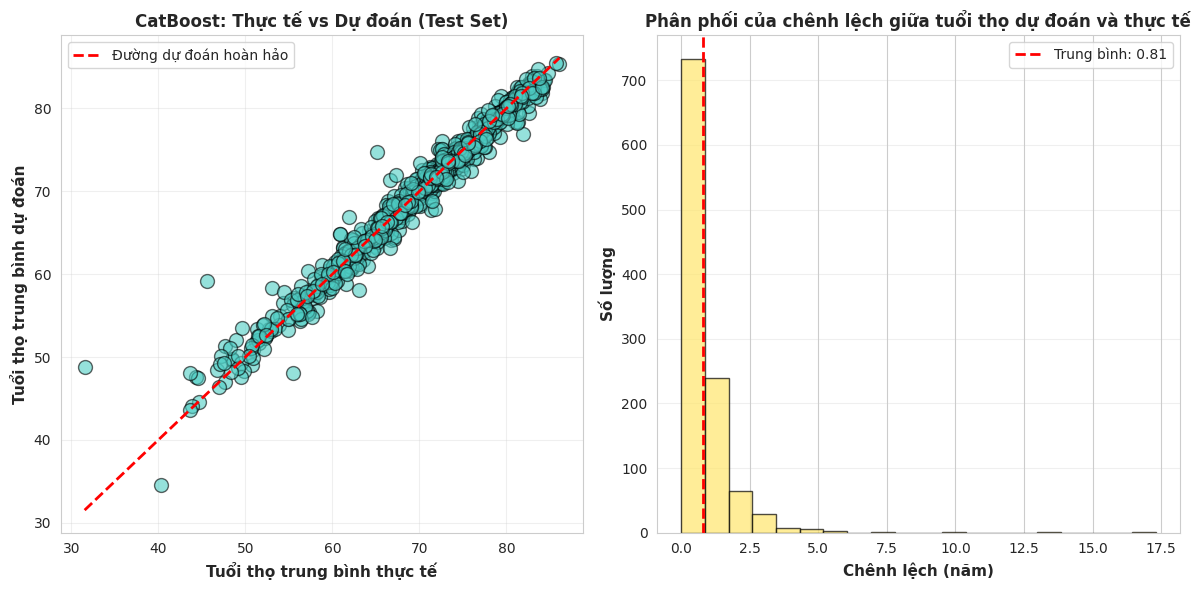

In [9]:
# 1. Biểu đồ so sánh các mô hình
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ con 1: Thực tế vs Dự đoán
ax1 = axes[0]
ax1.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k', s=100, color='#4ECDC4')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Đường dự đoán hoàn hảo')
ax1.set_xlabel('Tuổi thọ trung bình thực tế', fontsize=11, fontweight='bold')
ax1.set_ylabel('Tuổi thọ trung bình dự đoán', fontsize=11, fontweight='bold')
ax1.set_title(f'{best_model_name}: Thực tế vs Dự đoán (Test Set)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Biểu đồ con 2: Phân phối lỗi
ax2 = axes[1]
ax2.hist(test_results_df['Chênh lệch'], bins=20, edgecolor='black', alpha=0.7, color='#FFE66D')
ax2.axvline(test_results_df['Chênh lệch'].mean(), color='red', linestyle='--', linewidth=2, label=f"Trung bình: {test_results_df['Chênh lệch'].mean():.2f}")
ax2.set_xlabel('Chênh lệch (năm)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Số lượng', fontsize=11, fontweight='bold')
ax2.set_title('Phân phối của chênh lệch giữa tuổi thọ dự đoán và thực tế', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
os.makedirs('../model_selection', exist_ok=True)
plt.savefig('../model_selection/model_selection.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.2. Nhận xét về biểu đồ phân tích

- Biểu đồ bên trái cho thấy các dự đoán của CatBoost tập trung sát đường thẳng lý tưởng (đường đỏ), với ít điểm ngoại lệ, chứng tỏ mô hình có khả năng tổng quát hóa trên test set.

- Phân phối chênh lệch tuổi thọ dự đoán và thực tế hầu hết tập trung ở dưới 2 năm, với mức trung bình là 0.85 năm - rất tốt cho ứng dụng thực tế.

### 8.3. Phân tích sự vượt trội của CatBoost so với các mô hình khác
Qua các bước kiểm nghiệm phía trên, ta nhận thấy CatBoost cho kết quả tốt hơn hẳn các model khác dựa trên cả 3 metrics: MAE, RMSE và R2.

#### Vì sao CatBoost vượt trội?

1. Tránh overfitting tốt hơn XGBoost và LightGBM

2. Tính ổn định cao trên dữ liệu nhỏ
   - Bộ dữ liệu này chỉ có ~200 quốc gia, tương đối nhỏ.
   - CatBoost được thiết kế để hoạt động tốt trên dữ liệu nhỏ/trung bình.

3. Khả năng tổng quát hóa cao
   - Validation MAE của CatBoost là 0.8558, chỉ bằng 80% MAE của Linear model (> 1.0)
   - Điều này cho thấy CatBoost tìm được pattern phức tạp mà các mô hình đơn giản bỏ sót.

#### Điều này nói lên điều gì?

1. Dữ liệu hiện có có cấu trúc phi tuyến phức tạp.
   - Các mô hình tuyến tính (Linear, Ridge, Lasso) cho MAE ~3.5+ năm, cho thấy tuổi thọ không phải hàm tuyến tính của các chỉ số kinh tế-xã hội.
   - Tuổi thọ phụ thuộc vào tương tác phức tạp giữa nhiều yếu tố (GDP bình quân đầu người + tỷ lệ đô thị hóa + y tế + giáo dục,...)

2. Cấu trúc dữ liệu có "nhóm" rõ ràng.
   - CatBoost vượt trội hơn đáng kể, chứng tỏ dữ liệu có thể chia thành các nhóm quốc gia với pattern riêng biệt.
   - Ví dụ: nhóm nước phát triển, nước đang phát triển, nước kém phát triển có mối quan hệ khác nhau giữa các chỉ số và tuổi thọ.

3. Mô hình ensemble (Voting Ensemble) không hoàn toàn tối ưu.
   - Voting Ensemble dùng trung bình có trọng số của 11 base learners, nhưng một số mô hình (Linear, Lasso,....) cho kết quả yếu hơn nhiều.
   - Nếu Voting Ensemble chỉ dùng CatBoost + XGBoost + LightGBM thì có thể sẽ cho kết quả tốt hơn.

## Bước 9 - Lưu kết quả

In [10]:
# Lưu các kết quả
os.makedirs('../model_selection', exist_ok=True)

# 1. Lưu ranking validation
val_df_results.to_csv('../model_selection/model_validation_ranking.csv', index=False)

# 2. Lưu kết quả test chi tiết
test_results_df.to_csv('../model_selection/test_predictions_detailed.csv', index=False)

# 3. Lưu so sánh val vs test
comparison_df.to_csv('../model_selection/validation_test_comparison.csv', index=False)

print("TÓM TẮT KẾT QUẢ")
print("="*100)
print(f"Mô hình tốt nhất: {best_model_name}")
print(f"Validation - MAE: {best_mae:.4f}, RMSE: {best_rmse:.4f}, R²: {best_r2:.4f}")
print(f"Test       - MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

TÓM TẮT KẾT QUẢ
Mô hình tốt nhất: CatBoost
Validation - MAE: 0.7922, RMSE: 1.1944, R²: 0.9801
Test       - MAE: 0.8081, RMSE: 1.3471, R²: 0.9754


## Kết luận

### Qua các bước tiến hành, ta đã:
1. So sánh tất cả 12 mô hình trên validation set.
2. Xác định mô hình tốt nhất dựa trên MAE metric.
3. Dự đoán tuổi thọ trên test set sử dụng mô hình tốt nhất.
4. Phân tích chi tiết kết quả:
   - Kết quả dự đoán từng quốc gia.
   - So sánh validation vs test performance.
   - Phân tích lỗi theo nhóm tuổi thọ.
   - Vẽ biểu đồ insights.
5. Lưu tất cả kết quả để phục vụ cho báo cáo.

### Kết luận:
   - CatBoost là lựa chọn tối ưu cho bài toán dự đoán tuổi thọ trung bình của các quốc gia dựa trên bộ dữ liệu từ World Bank.
   - CatBoost cho độ chính xác cao (MAE = 0.8558 năm), đủ tốt cho dự báo chính sách công khai.
   - Mô hình có thể triển khai trong thực tế với độ tin cậy cao.